# Stacking Ensemble

**base learner：**
- GBR、lightGBM、XGBoost、RandomForest、ExtraRandomTrees、SVR、KernelRidge

**meta learner：**
- XGBoost

In [1]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [5]:
dft_train_X.shape, exp_train_X.shape, mixed_test_X.shape, mixed_test_y.shape

((8275, 64), (2545, 64), (1170, 64), (1170,))

## Base Learners Train

In [ ]:
from sklearn.base import clone
# Import sklearn models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [12]:
# define dft_models with the best hyper parameters in the pervious step
dft_models = {
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=10, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    subsample=0.7, colsample_bytree=1.0,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),

    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=7, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),

    'KernelRidge': Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=8000, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=0.05, random_state=RANDOM_SEED))]), 
    
    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

# define exp_models with the best hyper parameters in the pervious step
exp_models = {
    # Kernel models
    'KernelRidge': Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=2000, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=0.05, random_state=RANDOM_SEED))]),
    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),

    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=7,
    max_features='sqrt', subsample=0.5, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.1, max_depth=-1, n_estimators=500,
    subsample=1.0, colsample_bytree=0.7,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),
    
    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9, reg_lambda=0.5, alpha=0.5,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),
}

In [13]:
meta_train_X = pd.DataFrame()
meta_train_y = exp_train_y
dft_trained_models = {}
model_number = 0
model_nums = len(dft_models)

# train dft models and add the predictions to the meta train set
for model_name, model in dft_models.items():
    model_number += 1
    print(f"[{model_number}/{model_nums} - {model_name}] Training...")
    # train the model
    dft_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)
    y_pred = dft_model.predict(exp_train_X)
    meta_train_X[model_name] = y_pred
    # save the model
    dft_trained_models[model_name] = dft_model

[1/7 - GBR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  43.6s
Model training completed!
[2/7 - LightGBM] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 64
[LightGBM] [Info] Start training from score 1.459625
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s
Model training completed!
[3/7 - XGBoost] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   3.6s
Model training completed!
[4/7 - RandomForest] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   9.9s
Model training completed!
[5/7 - ExtraRandomTrees] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training completed!
[6/7 - KernelRidge] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 3.7min
Model training completed!
[7/7 - SVR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  10.4s
Model training complete

In [15]:
meta_train_X

,GBR,LightGBM,XGBoost,RandomForest,ExtraRandomTrees,KernelRidge,SVR
0,0.633845,0.760310,0.671610,0.772155,0.738184,0.757453,0.896624
1,0.473109,-0.162562,0.329665,0.558580,0.547890,0.042892,-0.096165
2,0.406758,0.475209,0.391149,0.478658,0.496123,0.108099,0.094632
3,0.326337,0.389463,0.291007,0.325297,0.308498,0.200572,0.230462
4,1.818293,1.848539,1.785179,1.677941,1.716402,1.629920,1.663697
...,...,...,...,...,...,...,...
2540,1.057413,1.038837,1.075922,1.026371,0.995871,1.078373,1.074618
2541,1.057413,1.038837,1.075922,1.026371,0.995871,1.078373,1.074618
2542,1.165824,1.118987,1.157428,1.158797,1.098589,1.023572,1.096304
2543,0.623249,0.598478,0.725606,0.636767,0.767418,0.637372,0.582808


In [17]:
exp_trained_models = {}
model_number = 0
model_nums = len(exp_models)
exp_meta_train_X = pd.DataFrame()

# train exp models and add the predictions to the meta train set
for model_name, model in exp_models.items():
    model_number += 1
    print(f"[{model_number}/{model_nums} - {model_name}] Training...")
    # train the model
    # 使用五折交叉验证来训练实验数据集的模型，并将交叉验证预测结果添加到元训练集
    exp_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    y_pred = np.zeros(exp_train_X.shape[0])
    for train_index, val_index in kfold.split(exp_train_X):
        exp_model.train(exp_train_X.iloc[train_index], exp_train_y.iloc[train_index])
        y_pred[val_index] = exp_model.predict(exp_train_X.iloc[val_index])
    exp_meta_train_X[f"{model_name}_exp"] = y_pred
    # save the model    
    exp_trained_models[model_name] = exp_model

[1/7 - KernelRidge] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.9s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.1s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training comp

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12888
[LightGBM] [Info] Number of data points in the train set: 2036, number of used features: 64
[LightGBM] [Info] Start training from score 1.505997


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12838
[LightGBM] [Info] Number of data points in the train set: 2036, number of used features: 64
[LightGBM] [Info] Start training from score 1.504347


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12759
[LightGBM] [Info] Number of data points in the train set: 2036, number of used features: 64
[LightGBM] [Info] Start training from score 1.506891


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
[7/7 - XGBoost] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.8s
Model training completed!
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s
Model training completed!


In [18]:
exp_meta_train_X

,KernelRidge_exp,SVR_exp,RandomForest_exp,ExtraRandomTrees_exp,GBR_exp,LightGBM_exp,XGBoost_exp
0,0.381289,0.340041,0.267714,0.270000,0.242914,0.271763,0.261383
1,0.388809,0.330974,1.224977,1.071296,1.031325,0.858650,0.626770
2,0.652388,0.552048,0.890849,0.850380,0.820764,0.745018,0.753431
3,0.149978,0.139936,0.139968,0.135000,0.131037,0.134502,0.140136
4,2.688590,2.729835,2.756101,2.761111,2.761157,2.760731,2.754864
...,...,...,...,...,...,...,...
2540,2.314032,2.310288,2.298553,2.296923,2.295603,2.296607,2.300537
2541,2.300077,2.300212,2.286588,2.285714,2.288694,2.286494,2.290482
2542,2.809374,2.759946,2.771205,2.771667,2.775466,2.773311,2.774529
2543,1.751735,1.862392,1.996990,2.100000,1.956143,2.054813,2.021183


In [19]:
meta_train_X = pd.concat([meta_train_X, exp_meta_train_X], axis=1)
meta_train_X.head()

,GBR,LightGBM,XGBoost,RandomForest,ExtraRandomTrees,KernelRidge,SVR,KernelRidge_exp,SVR_exp,RandomForest_exp,ExtraRandomTrees_exp,GBR_exp,LightGBM_exp,XGBoost_exp
0,0.633845,0.760310,0.671610,0.772155,0.738184,0.757453,0.896624,0.381289,0.340041,0.267714,0.270000,0.242914,0.271763,0.261383
1,0.473109,-0.162562,0.329665,0.558580,0.547890,0.042892,-0.096165,0.388809,0.330974,1.224977,1.071296,1.031325,0.858650,0.626770
2,0.406758,0.475209,0.391149,0.478658,0.496123,0.108099,0.094632,0.652388,0.552048,0.890849,0.850380,0.820764,0.745018,0.753431
3,0.326337,0.389463,0.291007,0.325297,0.308498,0.200572,0.230462,0.149978,0.139936,0.139968,0.135000,0.131037,0.134502,0.140136
4,1.818293,1.848539,1.785179,1.677941,1.716402,1.629920,1.663697,2.688590,2.729835,2.756101,2.761111,2.761157,2.760731,2.754864


In [25]:
important_features_path = os.path.join(current_path, './metrics/feature_importance')
exp_important_features = pd.read_csv(os.path.join(important_features_path, 'exp', 'exp_XGBoost_feature_importance.csv'))
dft_important_features = pd.read_csv(os.path.join(important_features_path, 'dft', 'dft_XGBoost_feature_importance.csv'))

In [26]:
important_features = pd.concat([exp_important_features, dft_important_features], axis=0)

In [27]:
# whether to use important features of exp as meta features
USE_IMPORTANT_FEAT = True
important_features = important_features['Feature'].unique().tolist()


if USE_IMPORTANT_FEAT:
    important_features_train_df = exp_train_X[important_features].copy()
    meta_train_X = pd.concat([important_features_train_df, meta_train_X], axis=1)

    # add the important features to the test set
    meta_dft_test_X = dft_test_X[important_features].copy()
    meta_exp_test_X = exp_test_X[important_features].copy()
    meta_mix_test_X = mixed_test_X[important_features].copy()   
else:
    meta_dft_test_X = pd.DataFrame()
    meta_exp_test_X = pd.DataFrame()
    meta_mix_test_X = pd.DataFrame()


In [28]:
# add dft model predictions to the test set
for model_name, model in dft_trained_models.items():
    print(f"[DFT {model_name}] Predicting...")
    # predict the test set
    y_pred = model.predict(dft_test_X)
    meta_dft_test_X[model_name] = y_pred
    # predict the mixed test set
    y_pred = model.predict(mixed_test_X)
    meta_mix_test_X[model_name] = y_pred
    # predict the exp test set
    y_pred = model.predict(exp_test_X)
    meta_exp_test_X[model_name] = y_pred

# add exp model predictions to the test set
for model_name, model in exp_trained_models.items():
    print(f"[EXP {model_name}] Predicting...")
    # predict the test set
    y_pred = model.predict(dft_test_X)
    meta_dft_test_X[f"{model_name}_exp"] = y_pred
    # predict the mixed test set
    y_pred = model.predict(mixed_test_X)
    meta_mix_test_X[f"{model_name}_exp"] = y_pred
    # predict the exp test set
    y_pred = model.predict(exp_test_X)
    meta_exp_test_X[f"{model_name}_exp"] = y_pred


[DFT GBR] Predicting...
[DFT LightGBM] Predicting...
[DFT XGBoost] Predicting...


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[DFT RandomForest] Predicting...
[DFT ExtraRandomTrees] Predicting...
[DFT KernelRidge] Predicting...
[DFT SVR] Predicting...
[EXP KernelRidge] Predicting...
[EXP SVR] Predicting...
[EXP RandomForest] Predicting...
[EXP ExtraRandomTrees] Predicting...
[EXP GBR] Predicting...
[EXP LightGBM] Predicting...
[EXP XGBoost] Predicting...


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


####################################################################################################
Training Stacking XGBoost on train data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.2s
Model training completed!
[Train_error] Evaluating Stacking XGBoost on train set:


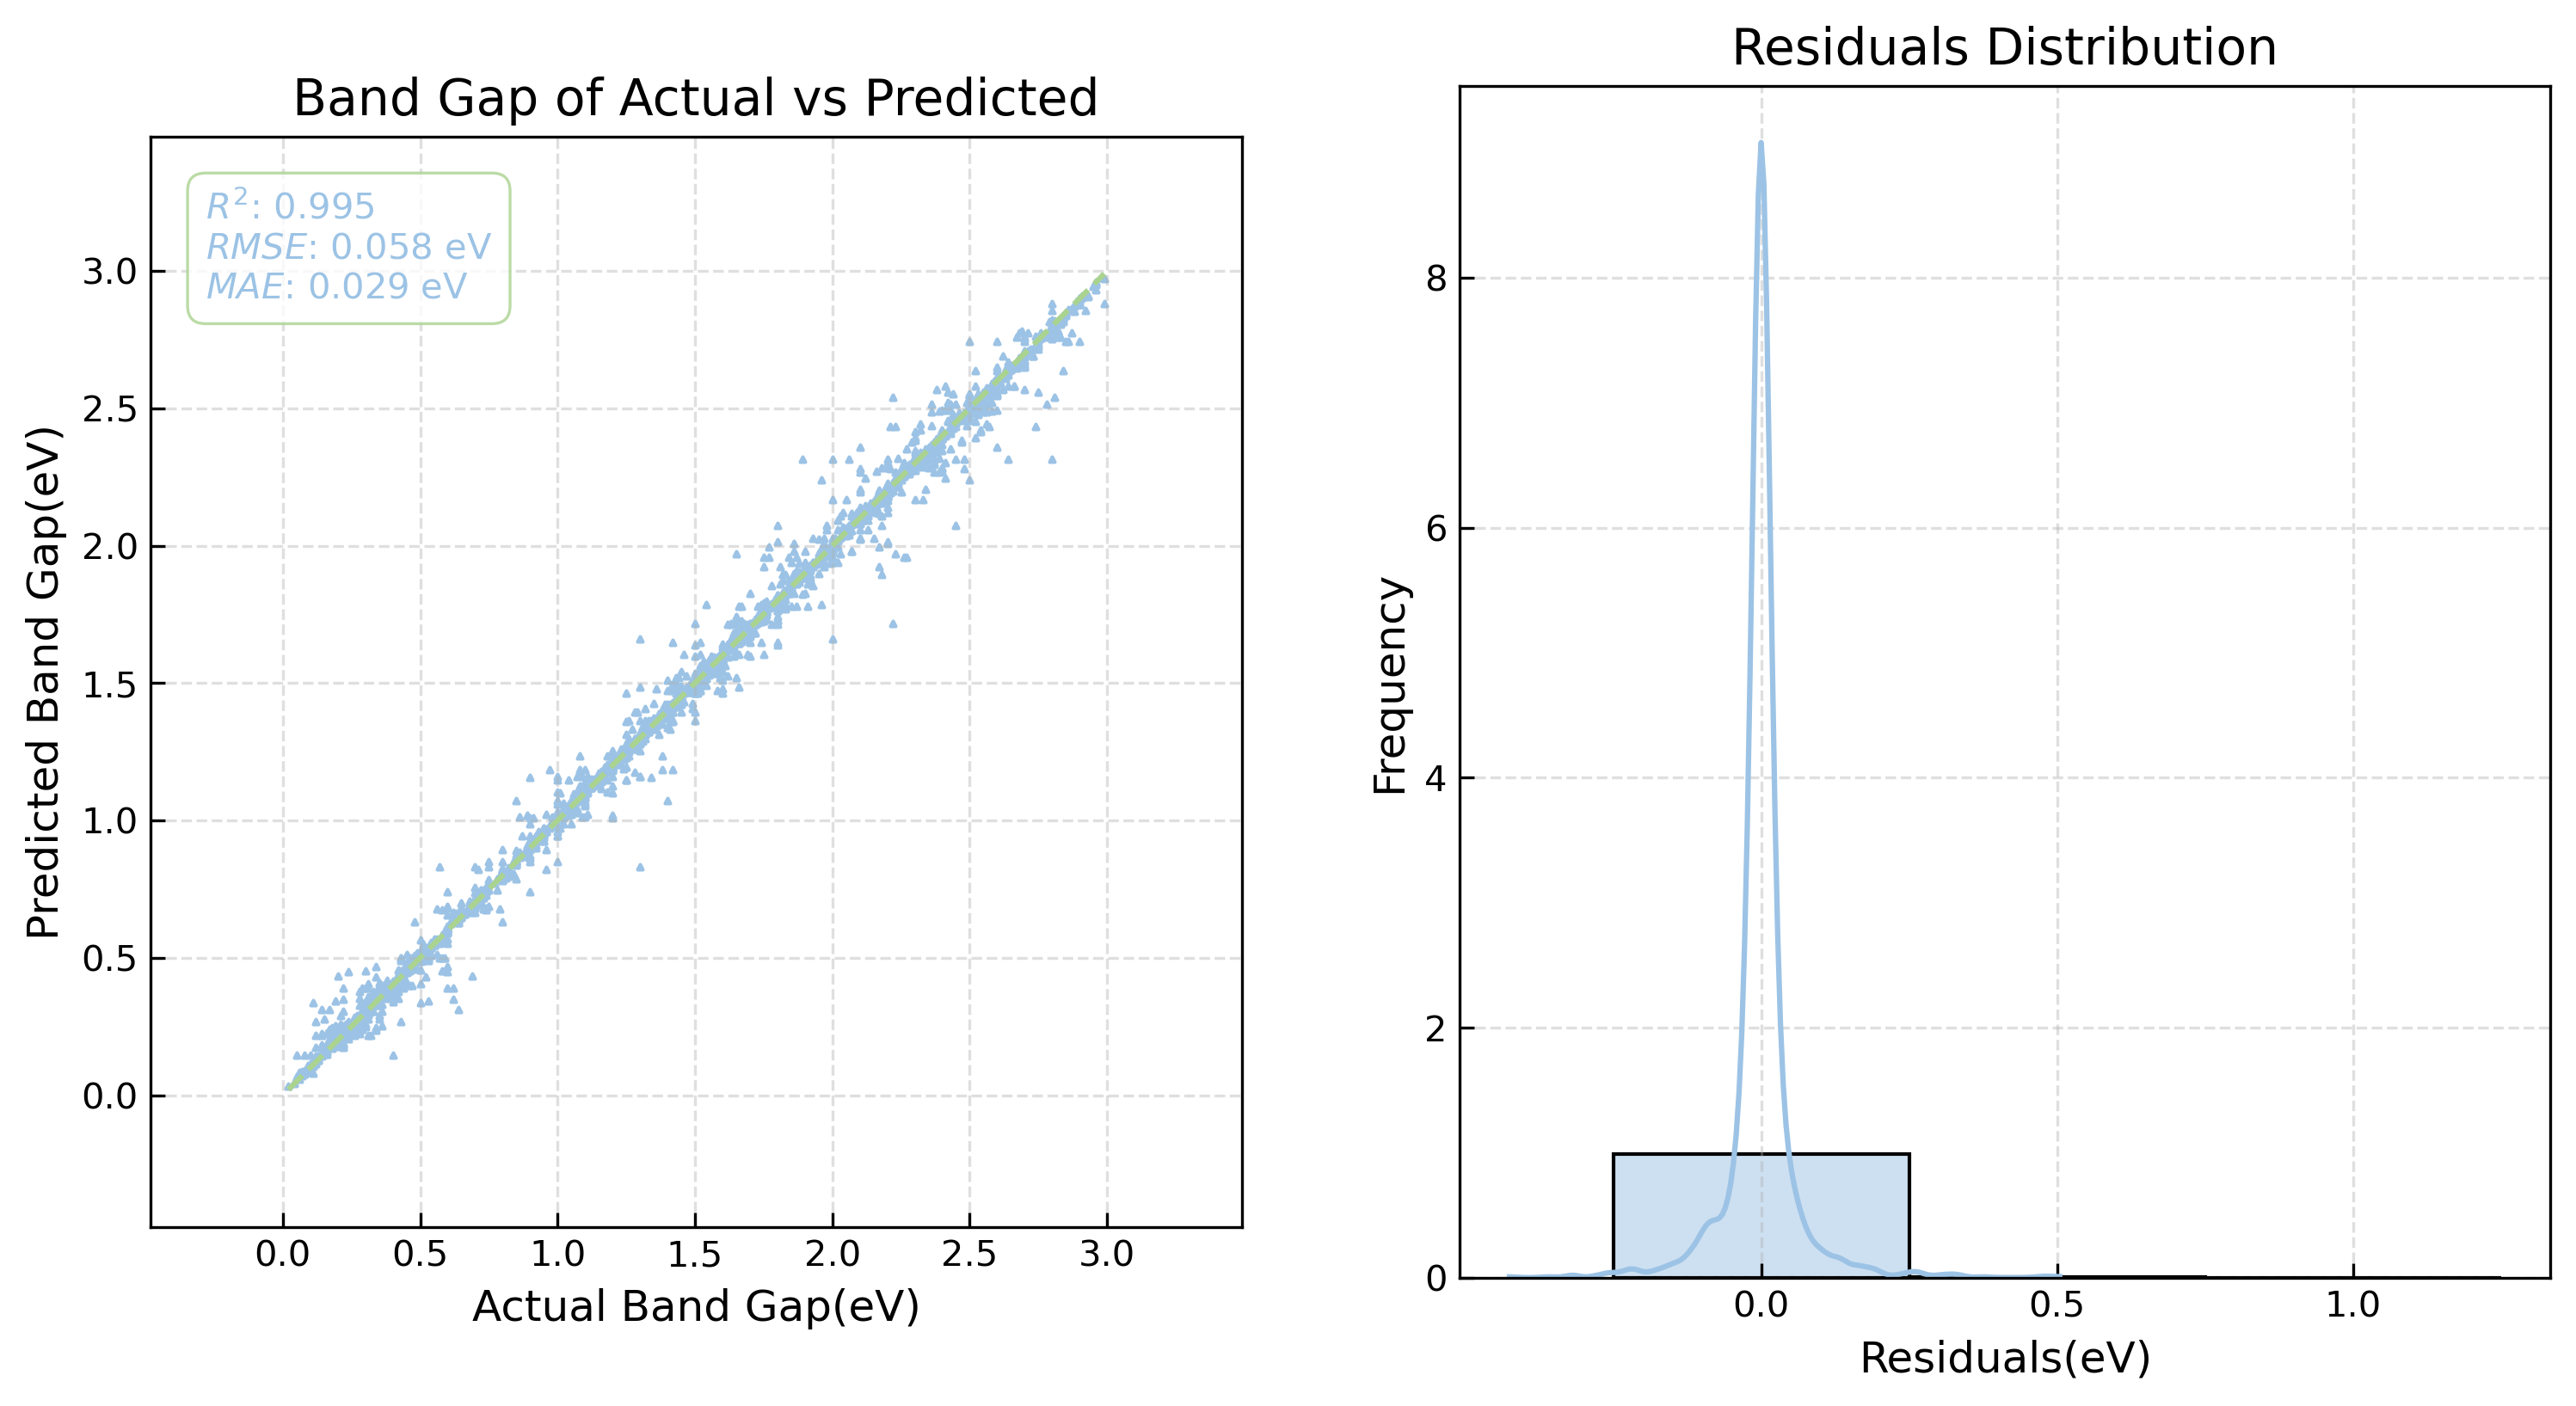


Model Evaluation Results:
Test set size: 2545
Test set: R²: 0.9948 RMSE: 0.0581 MAE: 0.0291 MAPE: 3.6247%
[Test Meta -> DFT] Evaluating Stacking XGBoost on DFT test set:


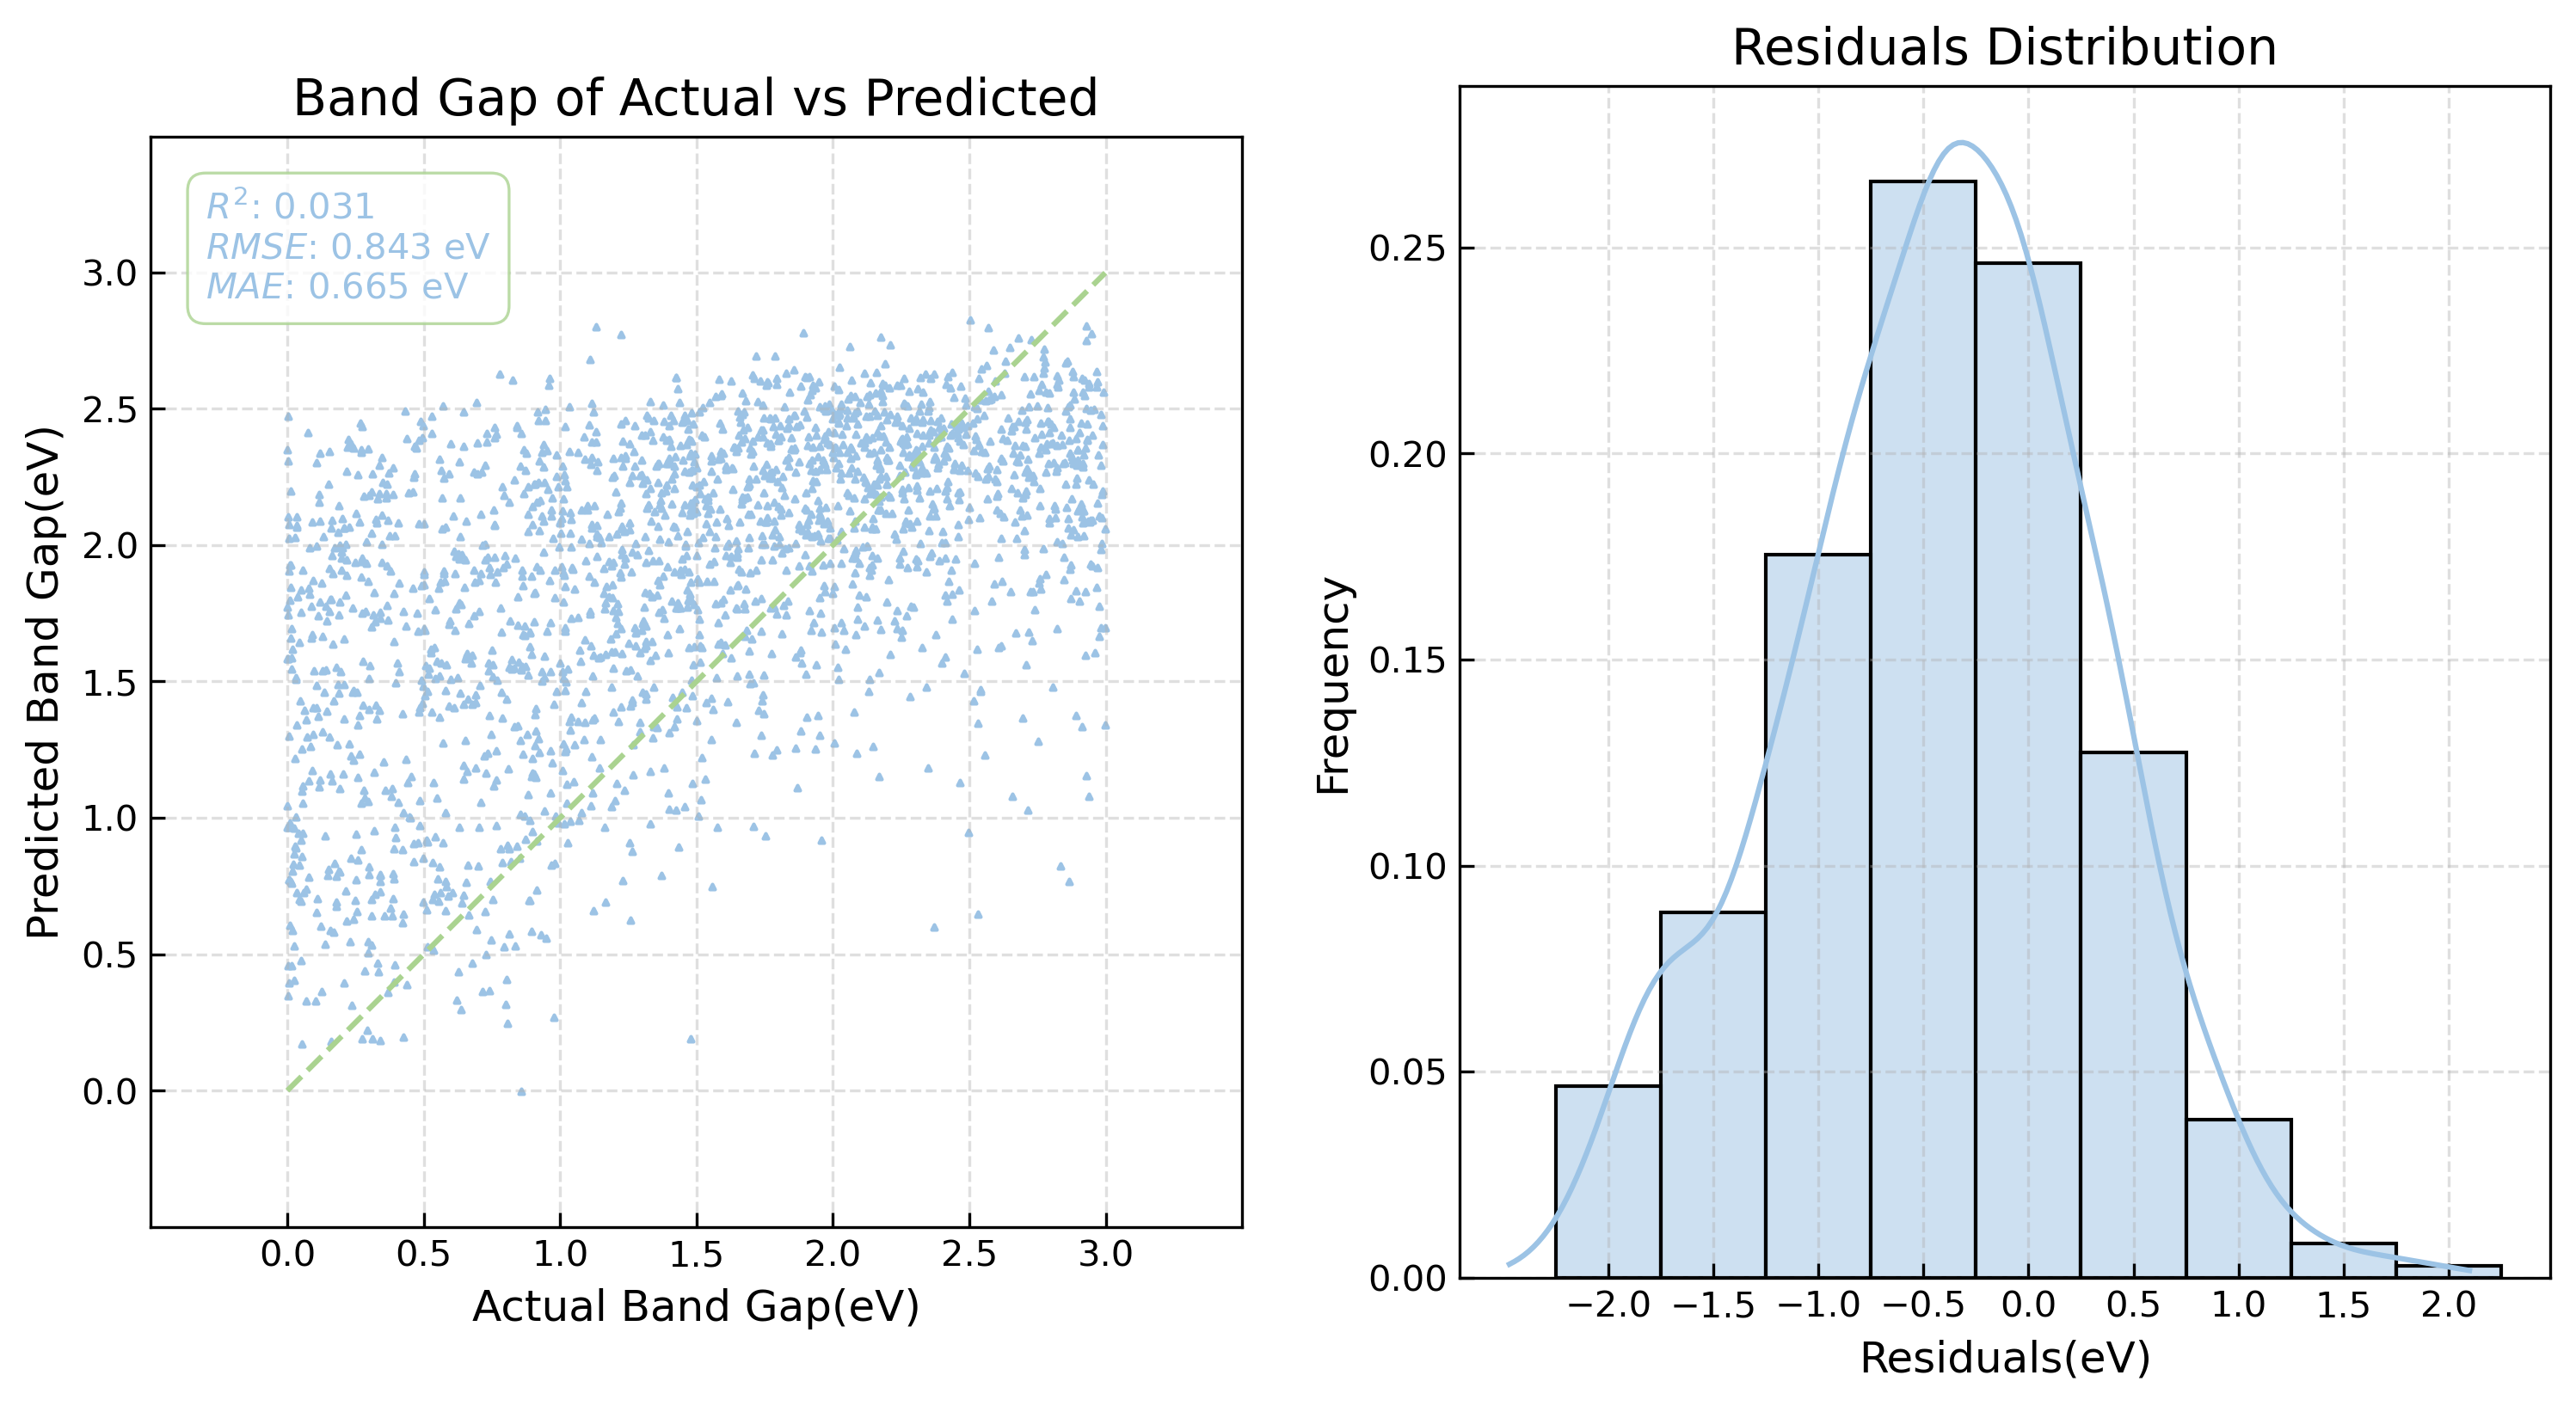


Model Evaluation Results:
Test set size: 2067
Test set: R²: 0.0311 RMSE: 0.8426 MAE: 0.6647 MAPE: 1700.9740%
[Test Meta -> EXP] Evaluating Stacking XGBoost on EXP test set:


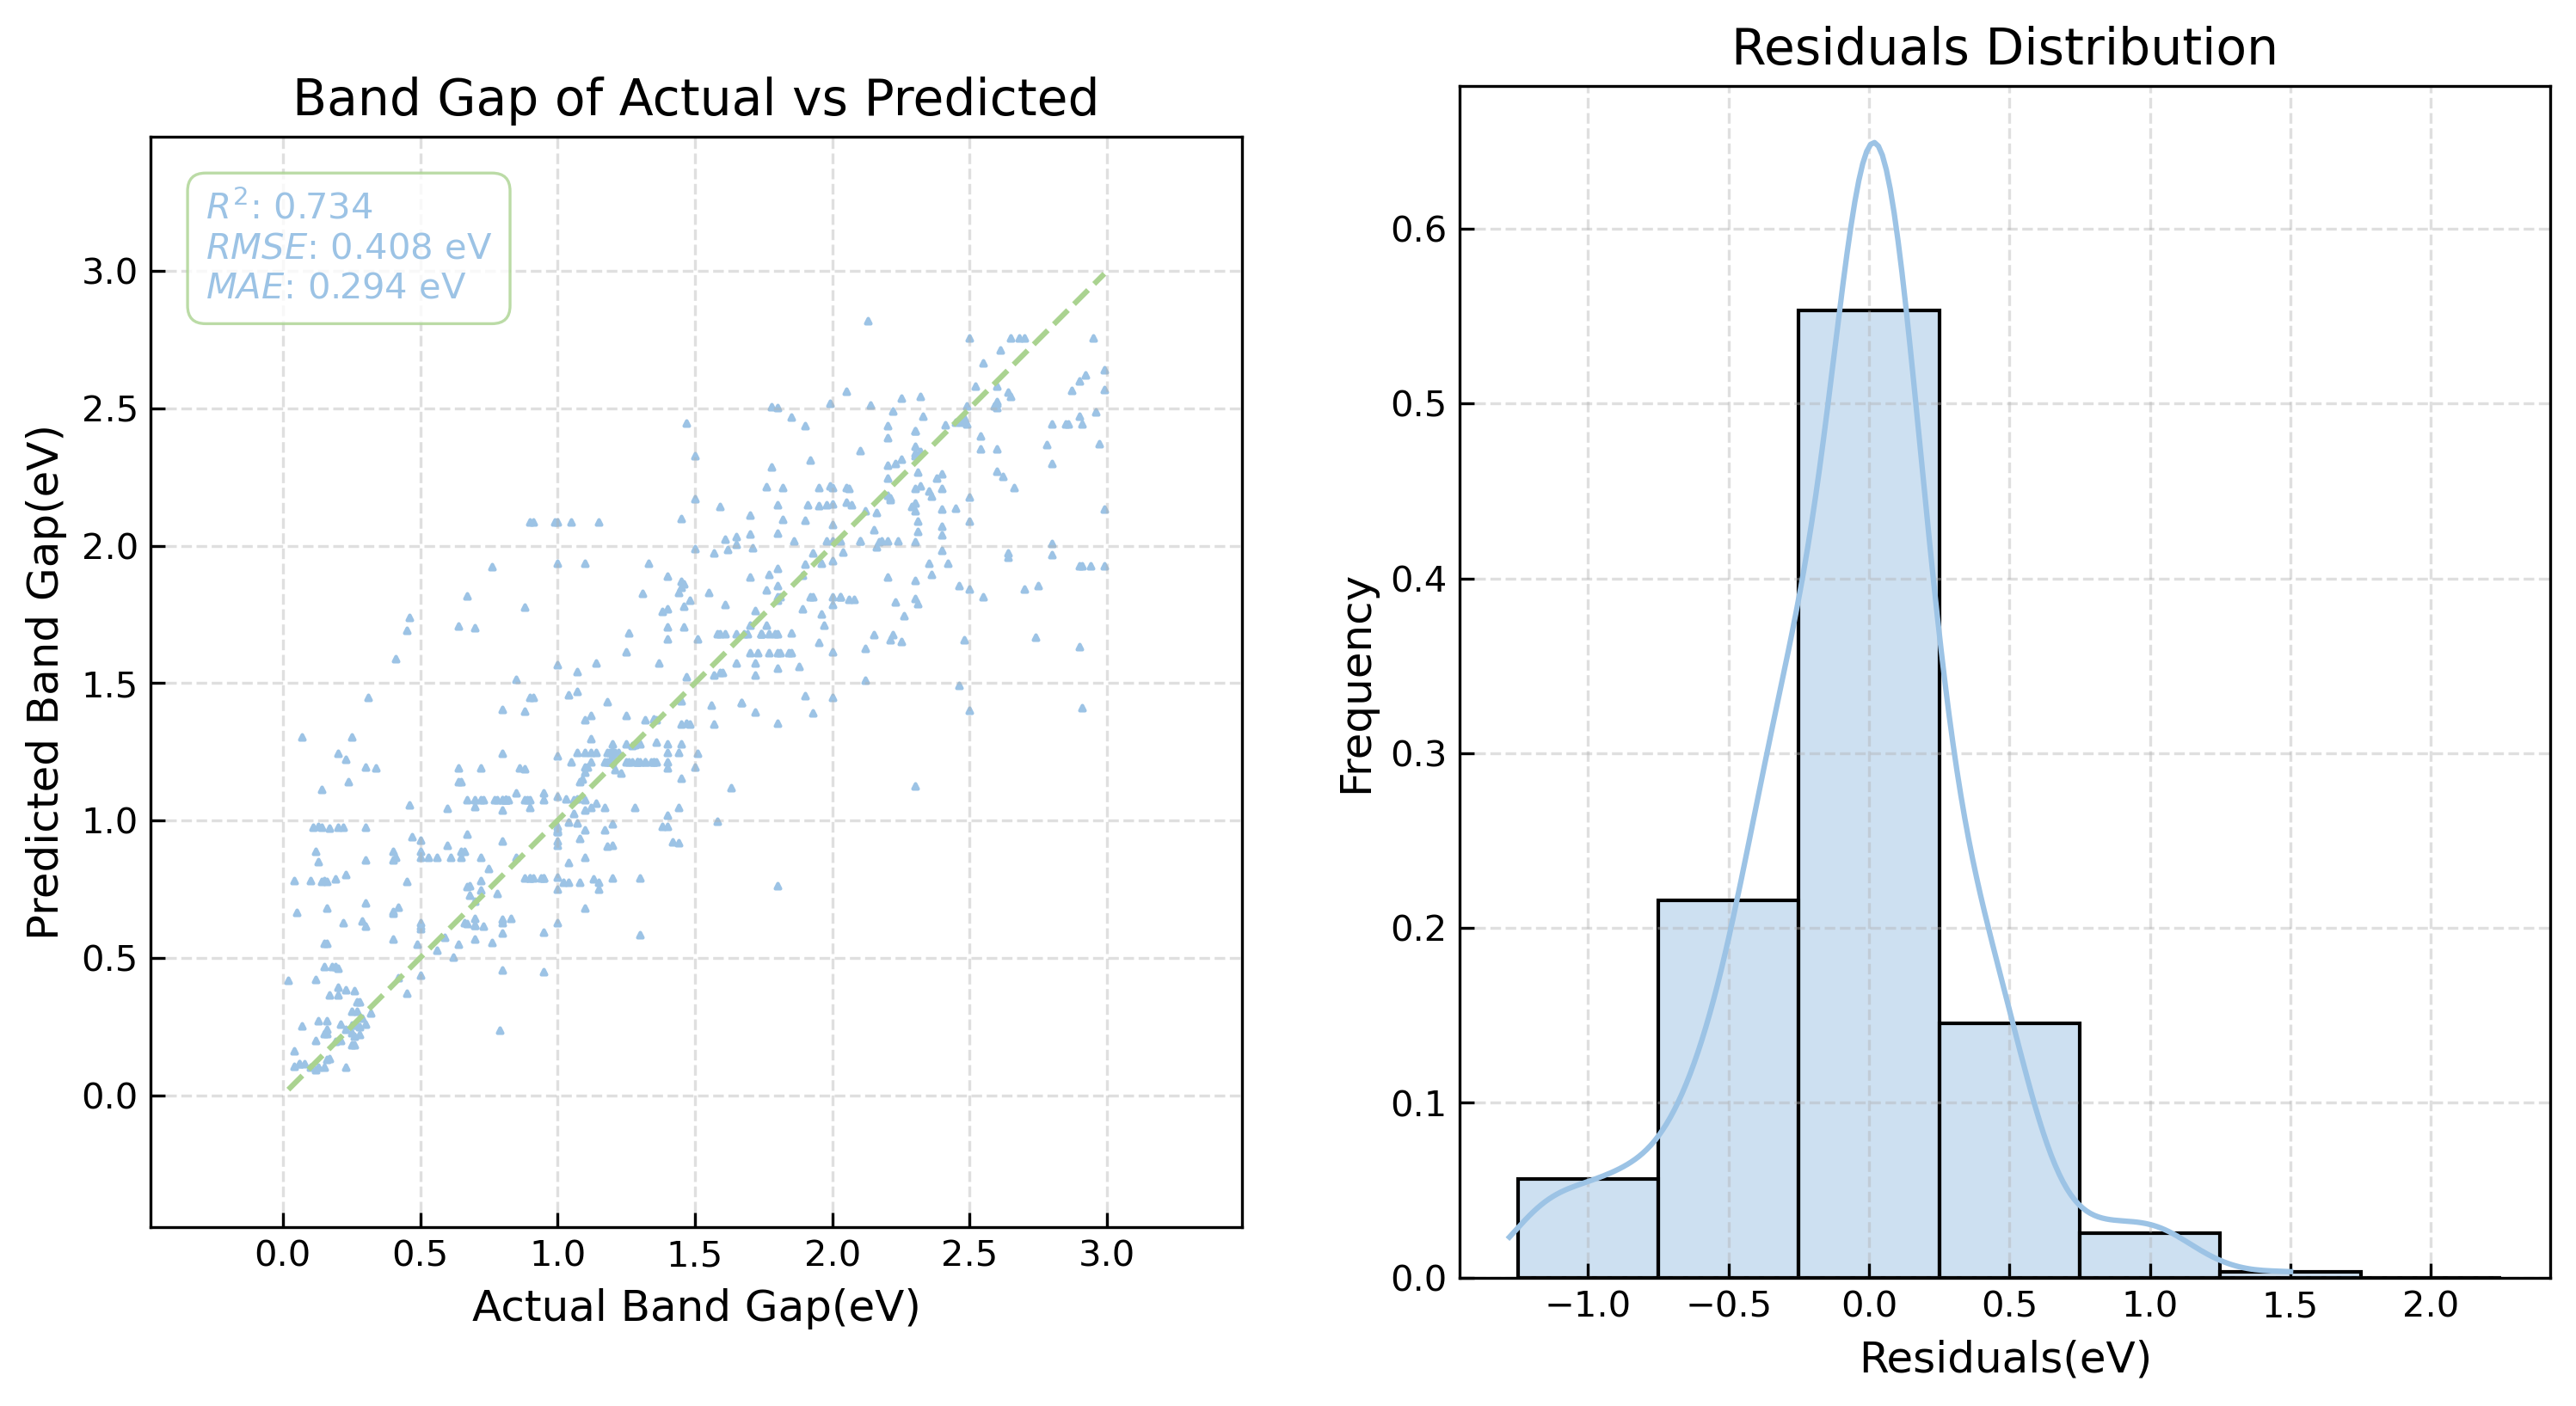


Model Evaluation Results:
Test set size: 585
Test set: R²: 0.7345 RMSE: 0.4084 MAE: 0.2943 MAPE: 57.8024%
[Test Meta -> MIX] Evaluating Stacking XGBoost on mixed test set:


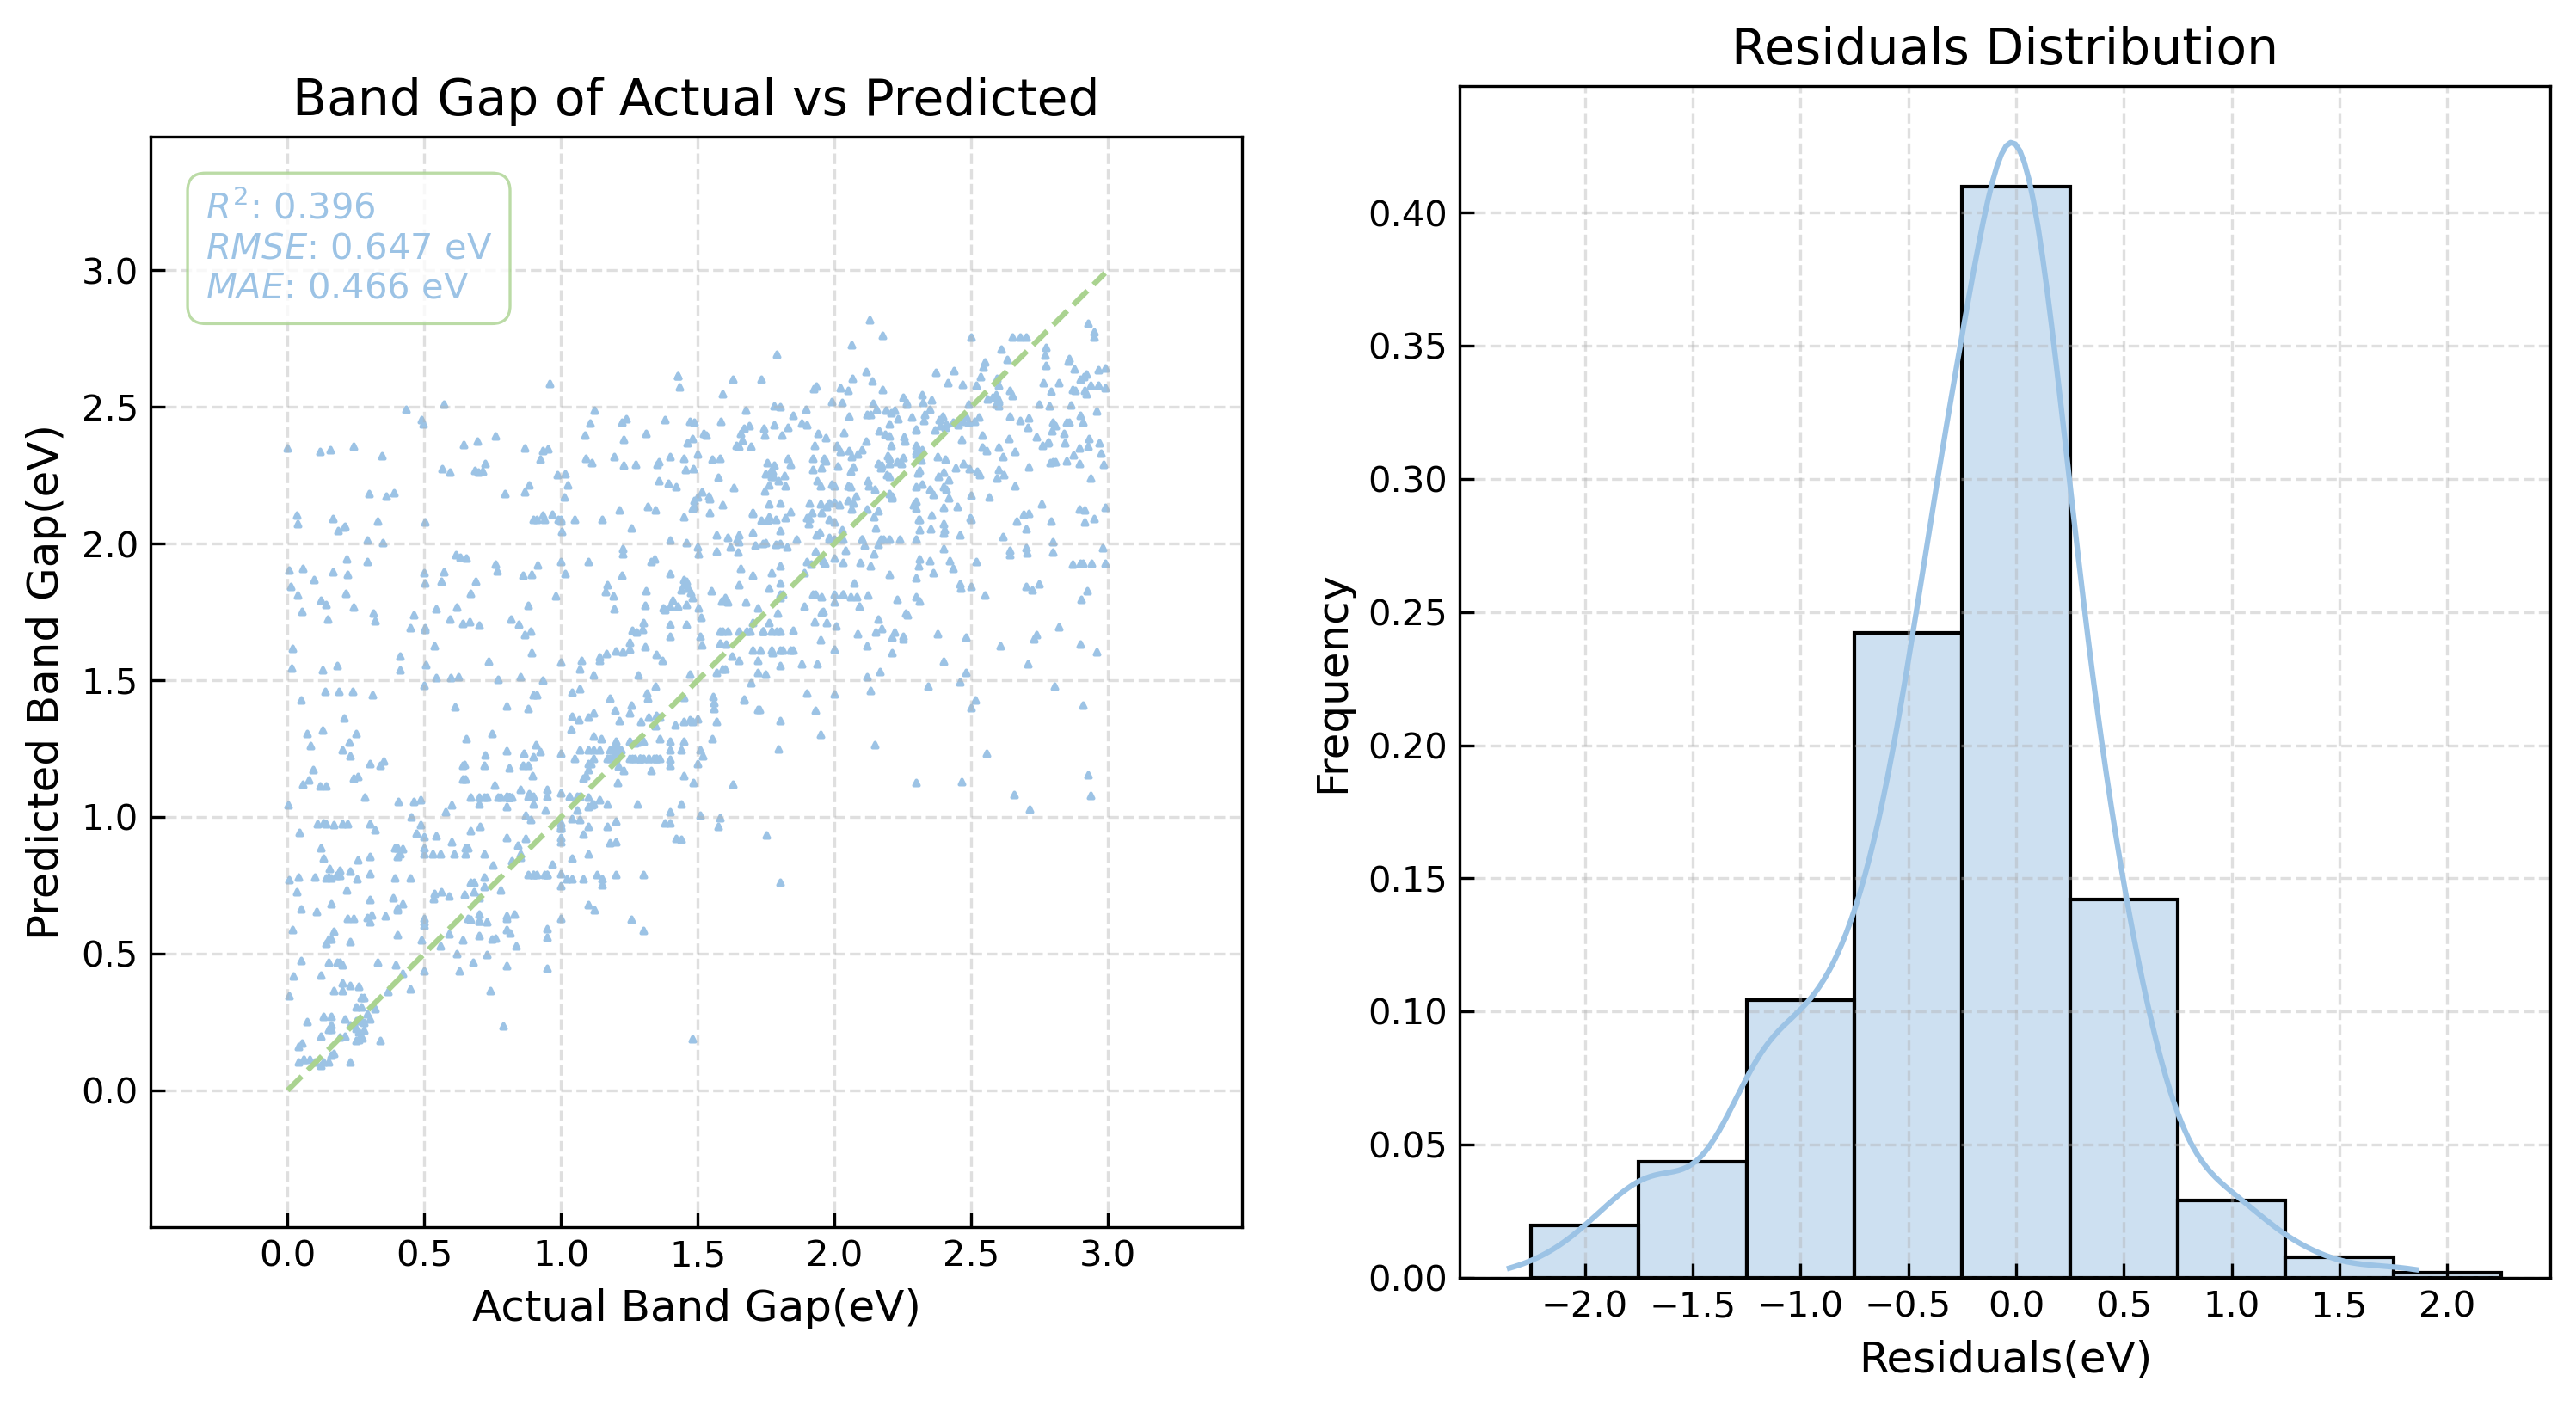


Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.3962 RMSE: 0.6470 MAE: 0.4657 MAPE: 1268.6611%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Stacking XGBoost,Train,meta,meta,0.994771,0.058077,0.029128
1,Stacking XGBoost,Test,meta,dft,0.031061,0.842551,0.664686
2,Stacking XGBoost,Test,meta,exp,0.734482,0.408415,0.294261
3,Stacking XGBoost,Test,meta,mix,0.396185,0.646996,0.465692


In [29]:
# meta model training
# 
MODEL_NAME = 'Stacking XGBoost'
# Train the model with the best hyperparameters on the entire training set
xgboost = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"Training {MODEL_NAME} on train data:")
print("-" * 100)

model = SingleModel(xgboost, random_state=RANDOM_SEED)
model.train(meta_train_X, meta_train_y)

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(meta_train_X, meta_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'meta',
'Test_set': 'meta',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test Meta -> DFT] Evaluating {MODEL_NAME} on DFT test set:")
metrics = model.evaluate(meta_dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test Meta -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(meta_exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test Meta -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(meta_mix_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join('./metrics', 'stacking_metrics.csv'), index=False)
model_metrics